In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyhacores.utils import *
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Application

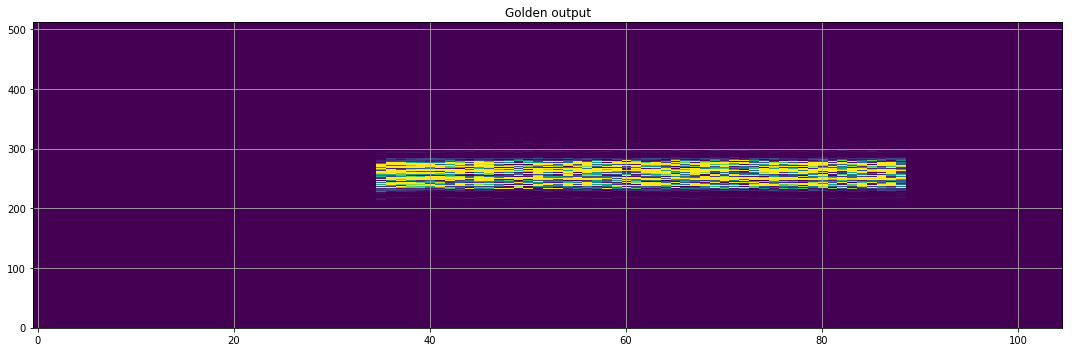

In [14]:
from pyhacores.utils import *
from scipy import signal
fft_size = 512
avg_freq_axis = 1
file = '/home/gaspar/git/pyhacores/data/f2404_fs16.896_one_hop.iq'
orig_inp = load_iq(file)
# orig_inp = orig_inp[:len(orig_inp)//fft_size*fft_size] # make sure sample count is divisible by fft_size
input_signal = orig_inp
# orig_inp = load_iq(file)[10000:12048]
# orig_inp = load_iq(file)[10000:10000 + fft_size * 2]

orig_inp = orig_inp - np.mean(orig_inp)
_, _, spectro_out = signal.spectrogram(orig_inp, 1, nperseg=fft_size, return_onesided=False, detrend=False,
                               noverlap=0, window='hann')

# fftshift
spectro_out = np.roll(spectro_out, fft_size//2, axis=0)

# avg decimation
x = np.split(spectro_out, len(spectro_out) // avg_freq_axis)
golden_output = np.average(x, axis=1)

plt.title('Golden output')
imshow(golden_output)

In [16]:
len(input_signal)

53888

## Spectrogram

In [17]:
from pyhacores.fft import Spectrogram
dut = Spectrogram(fft_size, avg_freq_axis=2, avg_time_axis=1)
sims = simulate(dut, input_signal.T, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...


ValueError: cannot reshape array of size 53888 into shape (512)

In [ ]:
snr(sims['MODEL'], sims['PYHA'])

In [ ]:
imshow(sims['PYHA'].T)

# Use `avg_freq_axis` to compress freq axis

In [ ]:
dut = Spectrogram(fft_size, avg_freq_axis=8, avg_time_axis=1)
sims = simulate(dut, input_signal.T, simulations=simulations)

In [ ]:
print(f"SNR: {snr(sims['MODEL'], sims['PYHA']):.2f}")
imshow(sims['PYHA'].T)

## Use `avg_time_axis` to compress time axis

In [ ]:
1024 / 8

In [ ]:
len(input_signal) // 8 * 8

In [ ]:
np.floor(len(input_signal) / 1024 / 4) * 1024 * 4

In [ ]:
len(input_signal) // 1024 * 1024

In [ ]:
(0.125) * 8

In [6]:
dut = Spectrogram(fft_size, avg_freq_axis=1, avg_time_axis=4)
sims = simulate(dut, input_signal.T, simulations=simulations)

NameError: name 'Spectrogram' is not defined

In [ ]:
print(f"SNR: {snr(sims['MODEL'], sims['PYHA']):.2f}")
imshow(sims['PYHA'].T)

# Limitations

## Uses `fullprecision` fixed-point

In [ ]:
print(f'Minimum number representabe: {2**-35}')

## Average pooling cannot be turned off i.e. setting `avg_freq_axis=1, avg_time_axis=1`
For this case the implementation could be simplified i.e. no need for high-precision fixed-point and read-modify-write.

# Synthesis
`avg_freq_axis` controls the memory usage and decimates the output data rate.

`avg_time_axis` decimates output data rate but has ~no effect on resource usage.

## `avg_freq_axis=1` and `avg_time_axis=2`

In [ ]:
dut = BitreversalFFTshiftAVGPool(fft_size, avg_freq_axis=1, avg_time_axis=2)
sims = simulate(dut, input_signal.T[:2], simulations=['MODEL', 'PYHA', 'RTL', 'GATE'])

In [ ]:
assert sims_close(sims, rtol=1e-10, atol=1e-10)

In [ ]:
lut, mem, mul = get_resource_usage()
print(f'Logic elements: {lut}')
print(f'Memory: {mem}')
print(f'Multipler (18bit): {mul//2}')

## `avg_freq_axis=4` and `avg_time_axis=1`

In [ ]:
# NBVAL_IGNORE_OUTPUT
dut = BitreversalFFTshiftAVGPool(fft_size, avg_freq_axis=4, avg_time_axis=1)
sims = simulate(dut, input_signal.T[:2], simulations=['MODEL', 'PYHA', 'RTL', 'GATE'])

In [ ]:
assert sims_close(sims, rtol=1e-9, atol=1e-9)

In [ ]:
lut, mem, mul = get_resource_usage()
print(f'Logic elements: {lut}')
print(f'Memory: {mem}')
print(f'Multipler (18bit): {mul//2}')